In [8]:
import numpy as np
import cv2
import random
import torch
from numpy import cos
from numpy import sin
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from utils import Bar, Logger, AverageMeter, accuracy, mkdir_p, savefig
import os
# from math  import log
from numpy  import log2
from numpy  import pi
from numpy  import exp
# from math  import log
from numpy  import log2
from numpy  import pi
from numpy  import exp
from numpy  import sqrt
# from numpy import (atleast_1d, eye, mgrid, argmin, zeros, shape, squeeze,
#                    vectorize, asarray, sqrt, Inf, asfarray, isinf)
# _epsilon = sqrt(np.finfo(float).eps)
# from optimize import fmin_cg
# from zeros import newton


In [9]:
flag_for=1


# <x, y> plane point <--> pixel coordinates <weighth, height>
range_x = (-2.2, 0.8)  # x coordinate range from image left to right f3
range_y = (-0.4, 1.1)  # y coordinate range from image bottom to top
# range_x = (-3, 3)  # x coordinate range from image left to right
# range_y = (-1.5, 1.5)  # y coordinate range from image bottom to top
WH = (2000, 1500)  # image resolution. For high resolution, you might need to enlarge the thickness of the drawn items
thickness=25

N_quantization_levels = 20   # quantize background color


output_dir = "./20181119/"  # remember to create that folder
# ----------------------------f1-------------------------
# FN_INDEX = 0  # select which function to draw. Start from 0!
# # H_INDEX=0
# opt_index = 4  # set parameters---------------------------
# x_init, y_init = -2, 1  # start point on the x-y plane
# start_point = [x_init, y_init]
# step = 0.012
# discount = 0.9
# epoch = 100
# epsilon = 1e-5
# yend = [0, 0]


# -----------------------------------------------------


# ---------------------f_trigonometric--------------------------------


FN_INDEX = 1  # select which function to draw. Start from 0!
# H_INDEX=0
opt_index=4#set parameters---------------------------
x_init, y_init = -2, 1 # start point on the x-y plane
start_point = [x_init,y_init]
step = 0.012
discount = 0.9
epoch=100
epsilon=1e-5
yend=[0,0]


# -----------------------------------------------------

# --------------------------f_rosenbrock---------------------------

# FN_INDEX =2  # select which function to draw. Start from 0!
# # H_INDEX=0
# opt_index=4#set parameters---------------------------
# x_init, y_init = 4, -1.5 # start point on the x-y plane
# start_point = [x_init,y_init]
# step = 0.00006
# discount = 0.7
# epoch=100
# epsilon=1e-2
# yend=[0,0]


# --------------------------f---------------------------


# --------------------------f_gold---------------------------

# FN_INDEX =3  # select which function to draw. Start from 0!
# # H_INDEX=0
# opt_index=4#set parameters---------------------------
# x_init, y_init = -4, 4.5 # start point on the x-y plane
# start_point = [x_init,y_init]
# step = 0.00000005
# discount = 0.9
# epoch=100
# epsilon=1e-2
# yend=[0,-1]



# --------------------------f-------------------------


def lossfn(yend, x):  # l2

    loss = np.linalg.norm(x - yend)
    return loss


# def lossfn(yend,x):#log_l2
#    loss= np.linalg.norm(x - yend)
#    loss=log2(loss)
#    return loss

# -------------------------------------------------
def fn(x_start, index=FN_INDEX):
    x = x_start[0]
    y = x_start[1]
    fn_list = [
        x * x + 50 * y * y,  # formula 1-------
        -(np.cos(x) + 1) * (np.cos(2 * y) + 1),  # formula tra-------------

        (1 - x) * (1 - x) + 100 * (y - x * x) * (y - x * x),  # rob

        (1 + (x + y + 1) * (x + y + 1) * (19 - 14 * x + 3 * x * x - 14 * y + 6 * x * y + 3 * y * y)) * (
                    30 + (2 * x - 3 * y) * (2 * x - 3 * y) * (
                        18 - 32 * x + 12 * x * x + 48 * y - 36 * x * y + 27 * y * y)),
        0.26 * (x * x + y * y) - 0.48 * x * y,  # gold


    ]
    return fn_list[index]


def g(x0, index=FN_INDEX):
    x = x0[0]
    y = x0[1]
    grad_list = [
        np.array([2 * x, 100 * y]),  # formula 1 's grad--------

        np.array([np.sin(x) * (np.cos(2 * y) + 1), 2 * np.sin(2 * y) * (np.cos(x) + 1)]),  # formula tra 's grad--------

        np.array([2 * x - 2 * x * (- 100 * x ** 2 + 100 * y) - 200 * x * (- x ** 2 + y) - 2, - 200 * x ** 2 + 200 * y]),
        # rob

        np.array([((6 * x + 6 * y - 14) * (x + y + 1) ** 2 + (2 * x + 2 * y + 2) * (
                    3 * x ** 2 + 6 * x * y - 14 * x + 3 * y ** 2 - 14 * y + 19)) * ((2 * x - 3 * y) ** 2 * (
                    12 * x ** 2 - 36 * x * y - 32 * x + 27 * y ** 2 + 48 * y + 18) + 30) + (
                              (x + y + 1) ** 2 * (3 * x ** 2 + 6 * x * y - 14 * x + 3 * y ** 2 - 14 * y + 19) + 1) * (
                              (8 * x - 12 * y) * (12 * x ** 2 - 36 * x * y - 32 * x + 27 * y ** 2 + 48 * y + 18) - (
                                  2 * x - 3 * y) ** 2 * (36 * y - 24 * x + 32)), (
                              (6 * x + 6 * y - 14) * (x + y + 1) ** 2 + (2 * x + 2 * y + 2) * (
                                  3 * x ** 2 + 6 * x * y - 14 * x + 3 * y ** 2 - 14 * y + 19)) * (
                              (2 * x - 3 * y) ** 2 * (
                                  12 * x ** 2 - 36 * x * y - 32 * x + 27 * y ** 2 + 48 * y + 18) + 30) - (
                              (x + y + 1) ** 2 * (3 * x ** 2 + 6 * x * y - 14 * x + 3 * y ** 2 - 14 * y + 19) + 1) * (
                              (12 * x - 18 * y) * (12 * x ** 2 - 36 * x * y - 32 * x + 27 * y ** 2 + 48 * y + 18) - (
                                  2 * x - 3 * y) ** 2 * (54 * y - 36 * x + 48))]),
 

    ]
    return grad_list[index]


In [10]:
#optimization method,momentum or m99-----------------------------

args = (2, 3, 7, 8, 9, 10)
def momentum(x_start,step, g, discount = 0.7):   # g代表了Gradient Descent
#     x0 = np.array(x_init, dtype='float64')
#     y0 = np.array(y_init, dtype='float64')
#     x=[x0,y0]
    x = np.array(x_start, dtype='float64')
    passing_dot = [x.copy()]
    pre_grad = np.zeros_like(x)
    pre_grad2 = np.zeros_like(x)
    loss_dot=[]
    for i in range(epoch):
        grad = g(x)
        pre_grad = pre_grad2 * discount + grad
        x -= pre_grad * step        
        passing_dot.append(x.copy())
        #print( '[ Epoch {0} ] grad = {1}, pre_grad = {2}, pre_grad2 = {3}, x = {4}'.format(i, grad,pre_grad,pre_grad2, x))
        pre_grad2=pre_grad 
#         loss_MSE=(x-[1,1])*(x-[1,1])
        loss_MSE= lossfn(yend, x)     
        loss_dot.append(loss_MSE)
        if abs(np.linalg.norm(x - yend)) < epsilon:
            print("m:"+str(i))
            break;       
    x_end=x
    print(x_end)
#     plt.plot(np.array((range(len(loss_dot)))),loss_dot,"-",label='momentum') 
    return x, passing_dot,loss_dot
def sgd(x_start,step, g):   # g代表了Gradient Descent  #for function1 120~150
#     x0 = np.array(x_init, dtype='float64')
#     y0 = np.array(y_init, dtype='float64')
#     x=[x0,y0]
    x = np.array(x_start, dtype='float64')
    passing_dot = [x.copy()]
    pre_grad = np.zeros_like(x)
    pre_grad2 = np.zeros_like(x)
    loss_dot=[]
    for i in range(epoch):
        grad = g(x)
        x -= grad * step        
        passing_dot.append(x.copy())
        loss_MSE= lossfn(yend, x)
        loss_dot.append(loss_MSE)
        #print( '[ Epoch {0} ] grad = {1}, pre_grad = {2}, pre_grad2 = {3}, x = {4}'.format(i, grad,pre_grad,pre_grad2, x))     
        if abs(np.linalg.norm(x - yend)) < epsilon:
            print("sgd:"+str(i))

            break;
    x_end=x
    print(x_end)
#     plt.plot(np.array((range(len(loss_dot)))),loss_dot,"-",label='sgd') 
    return x, passing_dot,loss_dot
def nesterov(x_start, step, g, discount = 0.7):
    x = np.array(x_start, dtype='float64')
    passing_dot = [x.copy()]
    pre_grad = np.zeros_like(x)
    loss_dot=[]
    for i in range(epoch):
        x_future = x - step * discount * pre_grad
        grad = g(x_future)
        pre_grad = pre_grad * discount + grad 
        x -= pre_grad * step
        passing_dot.append(x.copy())
        loss_MSE= lossfn(yend, x)
        loss_dot.append(loss_MSE)
        #print '[ Epoch {0} ] grad = {1}, x = {2}'.format(i, grad, x)
        if abs(np.linalg.norm(x - yend)) < epsilon:
            print("nag:"+str(i))
            break;
    x_end=x
    print(x_end)
#     plt.plot(np.array((range(len(loss_dot)))),loss_dot,"-",label='nesterov') 
    return x, passing_dot,loss_dot
def m99(x_start,step, g, discount = 0.7):   # gd代表了Gradient Descent
    x = np.array(x_start, dtype='float64')
    passing_dot = [x.copy()]
    pre_grad = np.zeros_like(x)
    pre_grad2 = np.zeros_like(x)
    loss_dot=[]
    for i in range(epoch):
        grad = g(x)
        sign=np.sign(grad) * np.sign(pre_grad2)
        sign=np.clip(sign,-1,0)
        pre_grad2=pre_grad2+(1*sign*pre_grad2)
        pre_grad = pre_grad2 * discount + grad
        x -= pre_grad * step        
        passing_dot.append(x.copy())
        loss_MSE= lossfn(yend, x)
        loss_dot.append(loss_MSE)
        #print( '[ Epoch {0} ] grad = {1}, pre_grad = {2}, pre_grad2 = {3}, x = {4}'.format(i, grad,pre_grad,pre_grad2, x))
        pre_grad2=pre_grad      
        if abs(np.linalg.norm(x - yend)) < epsilon:
            print("m99:"+str(i))
            break;
    x_end=x
    print(x_end)
#     plt.plot(np.array((range(len(loss_dot)))),loss_dot,"-",label='m99') 
    return x, passing_dot,loss_dot
def m99jf(t,x_start,step, g, discount = 0.7):   # gd代表了Gradient Descent
    x = np.array(x_start, dtype='float64')
    passing_dot = [x.copy()]
    pre_grad = np.zeros_like(x)
    pre_grad2 = np.zeros_like(x)
    t=t
    loss_dot=[]
    for i in range(epoch):
        grad = g(x)
#         print(grad)
        T=(np.abs(grad)<t)
        pre_grad2=(T*pre_grad2)
        pre_grad = pre_grad2 * discount + grad
        x -= pre_grad * step        
        passing_dot.append(x.copy())
        loss_MSE= lossfn(yend, x)
        loss_dot.append(loss_MSE)
        #print( '[ Epoch {0} ] grad = {1}, pre_grad = {2}, pre_grad2 = {3}, x = {4}'.format(i, grad,pre_grad,pre_grad2, x))
        pre_grad2=pre_grad      
        if abs(np.linalg.norm(x - yend)) < epsilon:
            print("m99jf:"+str(i))
            break;
    x_end=x
    print(x_end)
#     plt.plot(np.array((range(len(loss_dot)))),loss_dot,"-",label='m99jf') 
    return x, passing_dot,loss_dot
# def cg(fn, start_point, fprime=g, args=args):   # gd代表了Gradient Descent
#     x = np.array(start_point, dtype='float64')
#     passing_dot = [x.copy()]
#     for i in range(50):
#         x=fmin_cg(fn, x, fprime=g, args=args,retall=1) 
#         a=x
#         passing_dot.append(a)     
#     return x, passing_dot
# def newtn(fn, start_point, fprime=g, args=(), tol=1.48e-8, maxiter=50,fprime2=None):   # gd代表了Gradient Descent
#     x = np.array(start_point, dtype='float64')
#     passing_dot = [x.copy()]
#     for i in range(50):
#         x=newton(fn, start_point, fprime=g, args=(), tol=1.48e-8, maxiter=50,fprime2=None)  
#         passing_dot.append(x.copy())     
#     return x, passing_dot
def frcg(fun,gfun,x0):
    #用FR共轭梯度法求解无约束问题
    #x0是初始点，fun和gfun分别是目标函数和梯度
    #x,val分别是近似最优点和最优值，k是迭代次数
    x0 = np.array(x0, dtype='float64')
    passing_dot = [x0.copy()]
    maxk = epoch
    rho = 0.6
    sigma = 0.4
    k = 0
    n = np.shape(x0)[0]
    itern = 0
    while k < maxk:
        gk = gfun(x0)
        itern += 1
        itern %= n
        if itern == 1:
            dk = -gk
        else:
            beta = 1.0*np.dot(gk,gk)/np.dot(g0,g0)
            dk = -gk + beta*d0
            gd = np.dot(gk,dk)
            if gd >= 0.0:
                dk = -gk
        if np.linalg.norm(gk) < epsilon:
            print("frcg:"+str(k))
            break
        m = 0
        mk = 0
        while m < 20:
            if fun(x0+rho**m*dk) < fun(x0) + sigma*rho**m*np.dot(gk,dk):
                mk = m
                
                break
            m += 1
        x0 += rho**mk*dk
        g0 = gk
        d0 = dk
        k += 1  
        x=x0
        passing_dot.append(x.copy())
#         loss_MSE=(x-[1,1])*(x-[1,1])
#         loss_dot.append(loss_MSE.copy())
#     return x0,fun(x0),k
    x_end=x
    print(x_end)
    return x, passing_dot
def nm(fun,gfun,hess,x0):
    # 用去阻尼牛顿法求解无约束问题
    #x0是初始点，fun，gfun和hess分别是目标函数值，梯度，海森矩阵的函数
    x0 = np.array(x0, dtype='float64')
    passing_dot = [x0.copy()]
    maxk = epoch#EPOCH
#     rho = 0.55
    sigma = 0.4
    k = 0
    while k < maxk:
        gk = gfun(x0)
        Gk = hess(x0)
        dk = -1.0*np.linalg.solve(Gk,gk)
        if np.linalg.norm(dk) < epsilon:
            print("new:"+str(k))
            break
#         m = 0
#         mk = 0
#         while m < 20:
#             if fun(x0+rho**m*dk) < fun(x0) + sigma*rho**m*np.dot(gk,dk):
#                 mk = m
#                 break
#             m += 1
#         x0 += rho**mk*dk
        x0 += dk
        k += 1
        x=x0
        passing_dot.append(x.copy())
#         loss_MSE=(x-[1,1])*(x-[1,1])
#         loss_dot.append(loss_MSE.copy())
    x_end=x
    print(x_end)
    return x, passing_dot
def dampnm(fun,gfun,hess,x0):
    # 用阻尼牛顿法求解无约束问题
    #x0是初始点，fun，gfun和hess分别是目标函数值，梯度，海森矩阵的函数
    x0 = np.array(x0, dtype='float64')
    passing_dot = [x0.copy()]
    maxk = epoch#EPOCH
    rho = 0.55
    sigma = 0.4
    k = 0
    while k < maxk:
        gk = gfun(x0)
        Gk = hess(x0)
        dk = -1.0*np.linalg.solve(Gk,gk)
        if np.linalg.norm(dk) < epsilon:
            print("zn:"+str(k))
            break
        m = 0
        mk = 0
        while m < 20:
            if fun(x0+rho**m*dk) < fun(x0) + sigma*rho**m*np.dot(gk,dk):
                mk = m
                break
            m += 1
        x0 += rho**mk*dk
        k += 1
        x=x0
        passing_dot.append(x.copy())
#         loss_MSE=(x-[1,1])*(x-[1,1])
#         loss_dot.append(loss_MSE.copy())
    x_end=x
    print(x_end)
    return x, passing_dot
def NE(g,H,start_point):#海森矩阵牛顿法
    x=start_point
    n=1
    x = np.array(x, dtype='float64')
    passing_dot = [x.copy()]
    a=g(x)[0]
    b=g(x)[1]
    ee=np.array([[a],[b]])
    e = (ee[0,0] ** 2 + ee[1,0] ** 2) ** 0.5
    while n<epoch and e> 1e-6:
        n=n+1
        d=-np.dot(np.linalg.inv(H(x)),ee)
        #d=-numpy.dot(numpy.linalg.pinv(G(x0,y0)),g(x0,y0))
        x[0]=x[0]+d[0,0]
        x[1]=x[1]+d[1,0]
        passing_dot.append(x.copy())
    return x, passing_dot
def newtons(fn,g,start_point):#简单实现牛顿法
    e=1e-6
    x = np.array(start_point, dtype='float64')
    passing_dot = [x.copy()]
    e_tmp = e+1
#     loop = 1
    while e_tmp>e:
#         print '########loop'+str(loop)
        k = g(x)
        xm = fn(x)
#         print 'xn='+str(xn)+',k='+str(k)+',y='+str(xm)
        q = xm/k
        x = x-q
        e_tmp = abs(0-fn(x))
#         print 'new xn='+str(xn)+',e='+str(e_tmp)+',q='+str(q)
#         loop=loop+1
        passing_dot.append(x.copy())
    return x, passing_dot


In [11]:
def map_xy_to_img_coords(xy, xy_range, coords_range):
    return np.interp(xy, xy_range, coords_range)

def generate_background_cost(range_x = (-1, 1), range_y = (-2, 2), WH = (480, 640), N_quantization_levels = 0):
    """
    <x, y> plane point --> pixel coordinates <weighth, height>
    origin at the bottom-left corner
    N_quantization_levels: quantization levels
        0 (default): don't quantize
        uint > 1: can observe contour lines
    """

                

                 
    range_x = np.linspace(range_x[0], range_x[1], WH[0])  # (W, ) origin at the bottom-left corner
    range_y = np.linspace(range_y[1], range_y[0], WH[1])  # (H, ) origin at the bottom-left corner
    y_np, x_np = np.meshgrid(range_y, range_x, indexing = 'ij')  # (H, W)
#     X=range_x
#     Y=range_y
#     Z = Y*2**(-X**2 - Y**2)
#     mesh(X,Y,Z)
    xy_np=[x_np,y_np]
    cost_np = fn(xy_np)
    if N_quantization_levels > 0:
        #from IPython.core.debugger import set_trace; set_trace()
        quantization_unit = (cost_np.max() - cost_np.min()) / N_quantization_levels
        cost_np = np.round((cost_np - cost_np.min()) / quantization_unit) * quantization_unit + cost_np.min()
    return cost_np

def map_cost_to_color(cost):
    HW = cost.shape
    img = np.zeros(HW + (3,)).astype(np.uint8)
    ## set HSV color based on cost
    img[:,:,0] = 50  # hue, in order to change color, please refer to: http://answers.opencv.org/upfiles/15186761085555681.png
    img[:,:,1] = np.interp(cost, [cost.min(), cost.max()], [255, 50]).astype(np.uint8)  # saturation
    img[:,:,2] = np.interp(cost, [cost.min(), cost.max()], [100, 255]).astype(np.uint8)    # value
    img_BGR = cv2.cvtColor(img, cv2.COLOR_HSV2BGR)
    return img_BGR

def draw_segments_on_img(img, segments_pts, thickness = 5000):
    
    for pt1, pt2 in zip(segments_pts[:-1], segments_pts[1:]):
        img = cv2.line(img, pt1 = tuple(pt1), pt2 = tuple(pt2), color = np.random.rand(3)*255, thickness = thickness)
    return img

In [12]:
# for t in [10,100,1000,10000,100000]:
i=-1
loss4=[]
xa,x_arr0,loss0  = momentum(start_point, step, g, discount)#momentum
xa,x_arr1,loss1  = sgd(start_point, step, g)#sgd
#         x_arr1 = m99jf(t,start_point,step, g, discount)[1]#sgd
xa,x_arr2,loss2  = nesterov(start_point, step, g, discount)#NAG
xa,x_arr3,loss3  = m99(start_point, step, g, discount)#我们的方式
xa,x_arr4,loss4  = m99jf(0.1,start_point, step, g, discount)#我们的方式
xa,x_arr5,loss5  = m99jf(1,start_point, step, g, discount)#我们的方式
xa,x_arr6,loss6  = m99jf(10,start_point, step, g, discount)#我们的方式
xa,x_arr7,loss7  = m99jf(100,start_point, step, g, discount)#我们的方式
xa,x_arr8,loss8  = m99jf(1000,start_point, step, g, discount)#我们的方式
# xa,x_arr7,loss7  = m99jf(2.5,start_point, step, g, discount)#我们的方式


str0 = ','.join(str(i) for i in loss0)
str1 = ','.join(str(i) for i in loss1)
str2 = ','.join(str(i) for i in loss2)
str3 = ','.join(str(i) for i in loss3)
str4 = ','.join(str(i) for i in loss4)
str5 = ','.join(str(i) for i in loss5)
str6 = ','.join(str(i) for i in loss6)
str7 = ','.join(str(i) for i in loss7)
str8 = ','.join(str(i) for i in loss8)
filename=('func:'+str(FN_INDEX)+'_lr:'+str(step)+'_r:'+str(discount)+'_xinit:'+str(x_init)+'_yinit:'+str(y_init)+'_epoch:'+str(epoch)+'.txt')
file = open(filename, 'w+')
file.writelines(str0+'\n')
file.writelines(str1+'\n')
file.writelines(str2+'\n')
file.writelines(str3+'\n')
file.writelines(str4+'\n')
file.writelines(str5+'\n')
file.writelines(str6+'\n')
file.writelines(str7+'\n')
file.writelines(str8+'\n')
file.close()

[-0.01089009 -0.00374024]
[-0.41899733  0.0027043 ]
[-4.20052095e-03 -4.33689056e-05]
m99:60
[4.70293531e-06 3.11839242e-10]
[-0.41899481  0.00371751]
[0.05517924 0.00325476]
[-0.01089009 -0.00374024]
[-0.01089009 -0.00374024]
[-0.01089009 -0.00374024]


In [13]:

#gai
cost = generate_background_cost(range_x, range_y, WH, N_quantization_levels = N_quantization_levels)
img_BGR = map_cost_to_color(cost)
cvt_x_to_w = lambda x: np.round(map_xy_to_img_coords(x, range_x, [0, WH[0]])).astype(np.uint16)  # map x axis to image weighth (left to right)
cvt_y_to_h = lambda y: np.round(map_xy_to_img_coords(y, range_y, [WH[1], 0])).astype(np.uint16)  # map y axis to image height (bottom to top)

args = (2, 3, 7, 8, 9, 10)
x_arr_list=[x_arr0,x_arr1,x_arr2,x_arr3,x_arr4,x_arr5,x_arr6,x_arr7,x_arr8] 
# x_arr_list=[x_arr0,x_arr1,x_arr2,x_arr3,x_arr4,x_arr6]

if flag_for ==1:    
    for opt_index in range(len(x_arr_list)):
#     for opt_index in range(2):
        xy_pts = np.array(x_arr_list[opt_index])
    # print(xy_pts)
    #----------------------------------------------------------
        img_BGR = map_cost_to_color(cost)
        img_coords_pts = np.c_[cvt_x_to_w(xy_pts[:,0]), cvt_y_to_h(xy_pts[:,1])] # convert xy values to img coordinates
        img_BGR = draw_segments_on_img(img_BGR, img_coords_pts, thickness = thickness)
        img_BGR = cv2.circle(img_BGR, (cvt_x_to_w(0), cvt_y_to_h(0)), color = (0, 255, 0), radius = 10, thickness = 5)  # draw origin of x-y plane
        img_BGR = cv2.circle(img_BGR, (cvt_x_to_w(x_init), cvt_y_to_h(y_init)), color = (255, 0, 0), radius = 20, thickness = -1)  # draw origin of x-y plane
        img_BGR = cv2.circle(img_BGR, (cvt_x_to_w(yend[0]), cvt_y_to_h(yend[1])), color = (0, 0, 255), radius = 20, thickness = -1)  # draw origin of x-y plane
        cv2.imwrite(os.path.join(output_dir, "{:02}_{}_{}_{:02}.png".format(FN_INDEX,x_init,y_init,opt_index)), img_BGR)

    print("ok")       
else:
#         xy_pts = np.array(x_arr_list[opt_index])
    xy_pts = np.array(x_arr0)
# print(xy_pts)
#----------------------------------------------------------
    img_BGR = map_cost_to_color(cost)
    img_coords_pts = np.c_[cvt_x_to_w(xy_pts[:,0]), cvt_y_to_h(xy_pts[:,1])] # convert xy values to img coordinates
    img_BGR = draw_segments_on_img(img_BGR, img_coords_pts, thickness = 5)
    img_BGR = cv2.circle(img_BGR, (cvt_x_to_w(0), cvt_y_to_h(0)), color = (0, 255, 0), radius = 5, thickness = 10)  # draw origin of x-y plane
    img_BGR = cv2.circle(img_BGR, (cvt_x_to_w(x_init), cvt_y_to_h(y_init)), color = (255, 0, 0), radius = 10, thickness = 3)  # draw origin of x-y plane
    img_BGR = cv2.circle(img_BGR, (cvt_x_to_w(yend[0]), cvt_y_to_h(yend[1])), color = (0, 0, 255), radius = 10, thickness = 3)  # draw origin of x-y plane
    #cv2.imwrite("T:"+"_"+str(FN_INDEX)+"_"+str(opt_index)+"_"+str(x_init)+"_"+str(y_init)+ ".jpg", img_BGR)
    cv2.imwrite(os.path.join(output_dir, "T:"+"_"+"{:02}_{}_{}_{:02}.png".format(FN_INDEX,x_init,y_init,opt_index)), img_BGR)
    print("ok")

# print("ok") 

ok


<function matplotlib.pyplot.show>

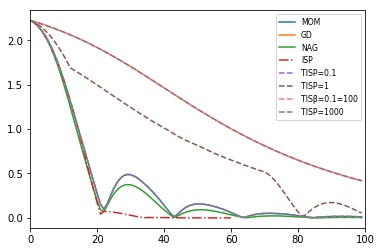

In [14]:

# MNIST Dataset
# logger = Logger(os.path.join('func_'+str(FN_INDEX)+'_'+str(step)+'_'+str(x_init)+'_'+str(y_init)+'.txt'), title='simple function')
# logger.set_names('Train Loss')
# logger.append(loss0)
# logger.append(loss1)
# logger.append(loss2)
# logger.append(loss3)
# logger.close()
# logger.plot()
# print(loss0)
# loss=[loss0,loss1,loss2,loss3,loss4,loss5,loss6,loss7,loss8]
# for i in range(len(loss)):
#     loss[i]=log(loss[i],2)
# loss0,loss1,loss2,loss3,loss4,loss5,loss6,loss7,loss8=loss
plt.plot(np.array((range(len(loss0)))),loss0,"-",label='MOM') 
plt.plot(np.array((range(len(loss1)))),loss1,"-",label='GD') 
plt.plot(np.array((range(len(loss2)))),loss2,"-",label='NAG') 
plt.plot(np.array((range(len(loss3)))),loss3,"-.",label='ISP')
plt.plot(np.array((range(len(loss4)))),loss4,"--",label='TISP=0.1')
plt.plot(np.array((range(len(loss5)))),loss5,"--",label='TISP=1')
# plt.plot(np.array((range(len(loss6)))),loss6,"--",label='TISP=10')
plt.plot(np.array((range(len(loss7)))),loss7,"--",label='TISβ=0.1=100')
plt.plot(np.array((range(len(loss8)))),loss8,"--",label='TISP=1000')

"""设置刻度"""
# plt.ylim(-40,10 )
# plt.yticks([-1,-0.5,0,0.5,1])
plt.xlim([0, 100])
# plt.xticks([-5,5,1])
# font = {'family': 'Times New Roman', 'weight': 'normal', 'size': 15}
font = {'size': 7.8}
plt.legend(loc = 0,ncol = 1,prop=font)
# plt.legend()
plt.show
